In [3]:
import pandas as pd
import numpy as np
import torch
import os
import hdbscan
import matplotlib.pyplot as plt

from utils import drop_skewed_features, drop_correlated_features
from aencoder import Autoencoder
from aencoder import train_autoencoder, get_latent_representation


random_seeds = [42, 44, 45, 48, 52]

/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [4]:
opt_params = {'silhouette_score': 0.5902, 'num_clusters': 9, 'skew_threshold': 0.8, 'corr_threshold': 0.5, 'hidden_size': 64, 'latent_dim': 2, 'learning_rate': 0.01, 'epochs': 500, 'hdbscan_params': {'min_cluster_size': 5, 'min_samples': 25}, 'dataset': 5}

## Load in dataset and opt parameters

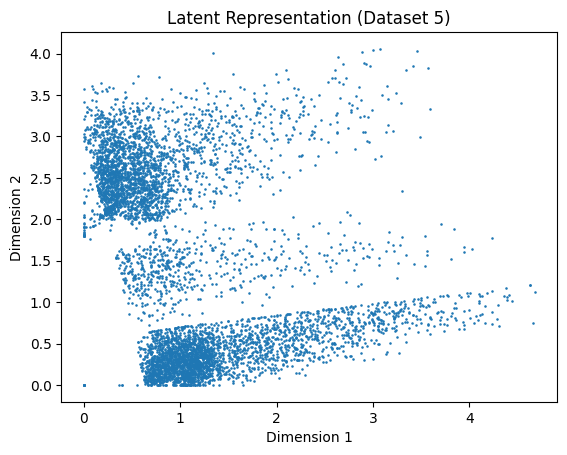

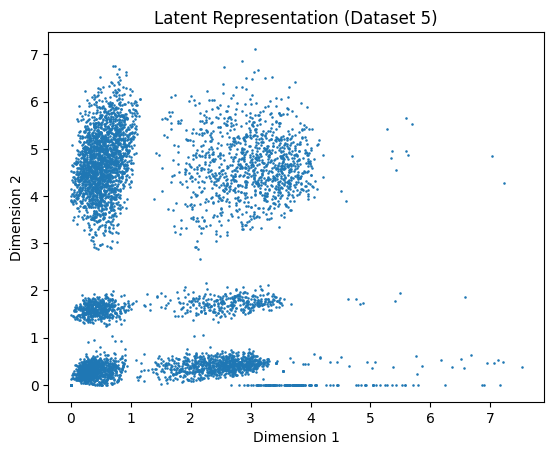

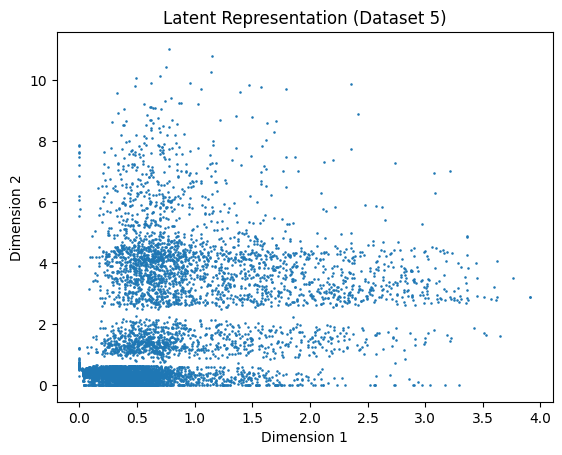

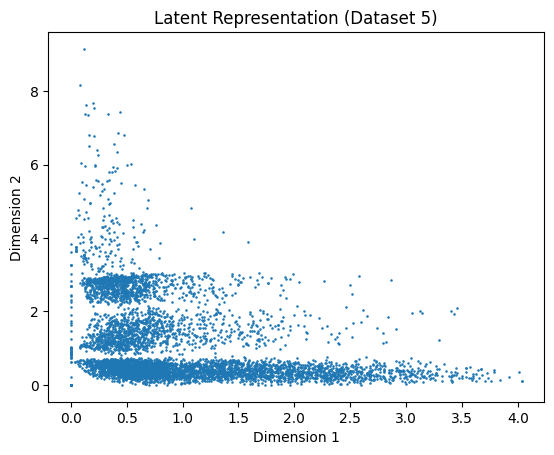

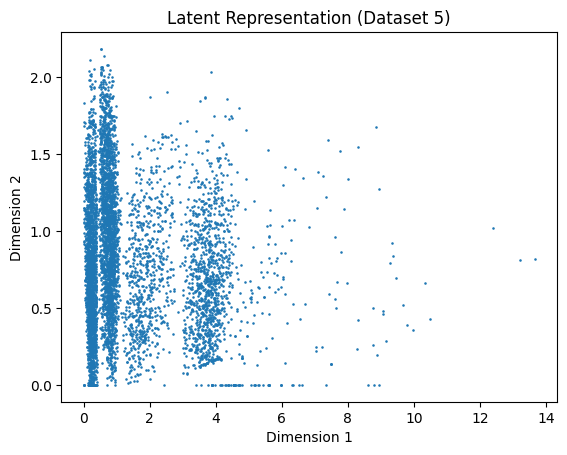

In [3]:
save_dir = '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/final'
os.makedirs(save_dir, exist_ok=True)

for seed in random_seeds:
    dataset = pd.read_csv(f'/Users/leo/Programming/PLR/Leo/data/dataset_{opt_params["dataset"]}.csv')
    dataset = drop_skewed_features(dataset, opt_params['skew_threshold'])
    dataset = drop_correlated_features(dataset, opt_params['corr_threshold'])
    tensor_dataset = torch.tensor(dataset.values.astype(np.float32))

    autoencoder = Autoencoder(tensor_dataset.shape[1], opt_params['hidden_size'], opt_params['latent_dim'], seed)
    trained_model = train_autoencoder(autoencoder, tensor_dataset, opt_params['learning_rate'], opt_params['epochs'])

    data_encoded = get_latent_representation(trained_model, tensor_dataset).detach().numpy()
    
    # Save the embedding
    embedding_filename = os.path.join(save_dir, f'embedding_seed_{seed}.npy')
    np.save(embedding_filename, data_encoded)

    # Visualize the representation
    plt.scatter(data_encoded[:, 0], data_encoded[:, 1], s=0.7)
    plt.title(f"Latent Representation (Dataset {opt_params['dataset']})")
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

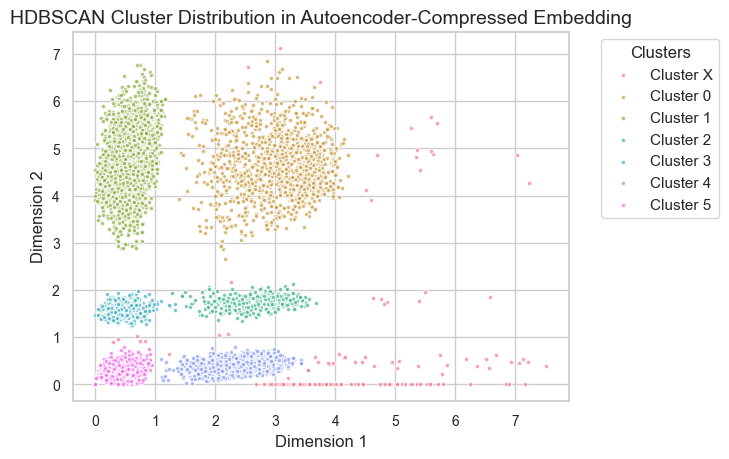

In [2]:
import numpy as np
import os
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def load_embedding(file_path):
    return np.load(file_path)

def apply_hdbscan(embedding, min_cluster_size, min_samples):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    cluster_labels = clusterer.fit_predict(embedding)
    return cluster_labels, clusterer

def find_best_clustering(embedding, min_cluster_sizes, min_samples_range, cluster_range):
    best_score = -1
    best_params = None
    best_labels = None

    for min_cluster_size in min_cluster_sizes:
        for min_samples in min_samples_range:
            labels, _ = apply_hdbscan(embedding, min_cluster_size, min_samples)
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise points labeled as -1

            # Check if the number of clusters is within the desired range
            if num_clusters in cluster_range:
                plot_title = f"Clustering: Min Cluster Size {min_cluster_size}, Min Samples {min_samples}, Clusters {num_clusters}"
                #plot_save_path = os.path.join(embedding_dir, f"cluster_plot_mcs{min_cluster_size}_ms{min_samples}.png")
                #plot_clusters(embedding, labels, plot_title, plot_save_path)

            # Update best score and parameters
            if num_clusters > 1:
                score = silhouette_score(embedding, labels)
                if score > best_score:
                    best_score = score
                    best_params = (min_cluster_size, min_samples)
                    best_labels = labels

    return best_score, best_params, best_labels

import seaborn as sns

def plot_clusters(embedding, labels, title, save_path=None):
    # Set style
    sns.set(style="whitegrid")

    # Create a color palette with enough colors
    unique_labels = np.unique(labels)
    palette = sns.color_palette("husl", len(unique_labels))

    # Create scatter plot
    for i, label in enumerate(unique_labels):
        # Check if the label is -1, and rename it to 'Cluster X'
        label_name = f'Cluster {label}' if label != -1 else 'Cluster X'

        plt.scatter(embedding[labels == label, 0], embedding[labels == label, 1], 
                    color=palette[i], label=label_name, 
                    edgecolor='w', s=10, alpha=0.7)

    # Add legend and title
    plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title, fontsize=14)

    # Fine-tune plot appearance
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

embedding_file = "/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl2/embedding_seed_44.npy"
min_cluster_range = range(135, 136)
min_samples_range = range(2, 3)

embedding = load_embedding(embedding_file)

cluster_count_range = range(6, 7)  # Specify your desired range of cluster counts here
best_score, best_params, best_labels = find_best_clustering(embedding, min_cluster_range, min_samples_range, cluster_count_range)

plot_title = "HDBSCAN Cluster Distribution in Autoencoder-Compressed Embedding"
#embedding_dir = os.path.dirname(embedding_file)
#plot_save_path = os.path.join(embedding_dir, "best_clustering_plot.png")
plot_clusters(embedding, best_labels, plot_title, "/Users/leo/Programming/PLR/Leo/main/final/plot.png")

In [9]:
def append_clusters_to_csv(cluster_labels, csv_path, output_path):
    # Load the original dataset
    df = pd.read_csv(csv_path)

    # Check if the length of cluster_labels matches the number of rows in the DataFrame
    if len(cluster_labels) != len(df):
        raise ValueError("The length of cluster_labels does not match the number of rows in the DataFrame")

    # Append the cluster labels as a new column
    df['cluster'] = cluster_labels

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_path, index=False)

    return df

csv_path = "/Users/leo/Programming/PLR/Leo/data/cleaned_data_SYMPTOMS_9_13_23.csv"
output_path = "//Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl2/cl2_full_dataset.csv"

append_clusters_to_csv(best_labels, csv_path, output_path)

,Unnamed: 0,Symptom_Memory_short,Symptom_Memory_long,Symptom_Memory_no_new_memories,Symptom_Memory_forget_tasks,Symptom_Memory_other,Symptom_Cognitive_Functioning_thinking,Symptom_Cognitive_Functioning_executive,Symptom_Cognitive_Functioning_problemsolving,Symptom_Cognitive_Functioning_slowedthoughts,...,Demographics_Age_Cleaned,Flag_MECFS,Flag_POTS,Flag_MCAS,FAS,FAS_cat,Physical_PEM_Severity,Cognitive_PEM_Severity,HasPeriods,cluster
0,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,30-39,1.0,"No, no tachycardia",1.0,20.0,Minimal/No Fatigue,5.0,5.0,NaN,1
1,5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,40-49,1.0,"No, no tachycardia",0.0,30.0,Fatigue,9.0,7.0,"No, other reason",1
2,6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,40-49,1.0,"Possible, had tachycardia/palpitations",0.0,20.0,Minimal/No Fatigue,8.0,0.0,"No, other reason",5
3,8,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,40-49,1.0,"Definite, measured bpm > 30",0.0,19.0,Minimal/No Fatigue,7.0,4.0,Yes,1
4,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,40-49,1.0,"Possible, had tachycardia/palpitations",0.0,20.0,Minimal/No Fatigue,10.0,0.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026,14158,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,50-59,1.0,"Possible, had tachycardia/palpitations",2.0,32.0,Fatigue,8.0,6.0,"No, post-menopausal",0
6027,14161,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,30-39,1.0,"Likely, had higher bpm standing",1.0,26.0,Fatigue,10.0,9.0,"No, other reason",4
6028,14163,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,30-39,0.0,"Definite, measured bpm > 30",1.0,33.0,Fatigue,8.0,7.0,Yes,1
6029,14166,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,60-69,0.0,"No, no tachycardia",0.0,18.0,Minimal/No Fatigue,NaN,NaN,NaN,5


In [81]:
def save_filtered_dataframe(df, original_file_path):
    # Filter the DataFrame to keep only the 'Unnamed: 0' and 'Cluster' columns
    filtered_df = df[['Unnamed: 0', 'cluster']]

    # Generate the new file path
    directory = os.path.dirname(original_file_path)
    new_file_name = "filtered_" + os.path.basename(original_file_path)
    new_file_path = os.path.join(directory, new_file_name)

    # Save the filtered DataFrame to CSV
    filtered_df.to_csv(new_file_path, index=False)

    return new_file_path

# Example usage
original_file_path = '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl2/cl2_full_dataset.csv'
df = pd.read_csv(original_file_path)
new_file_path = save_filtered_dataframe(df, original_file_path)

In [82]:
import os
import pandas as pd
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

def calculate_ari_ami_for_two(csv_path1, csv_path2):
    # Read clustering results from the two CSV files
    df1 = pd.read_csv(csv_path1)
    df2 = pd.read_csv(csv_path2)

    # Calculate ARI and AMI
    ari_score = adjusted_rand_score(df1['cluster'], df2['cluster'])
    ami_score = adjusted_mutual_info_score(df1['cluster'], df2['cluster'])

    print(f"ARI Score: {ari_score:.4f}")
    print(f"AMI Score: {ami_score:.4f}")

# Usage
csv_path1 = '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl2/filtered_cl2_full_dataset.csv'
csv_path2 = '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl3/filtered_cl3_full_dataset.csv'
calculate_ari_ami_for_two(csv_path1, csv_path2)



ARI Score: 0.0083
AMI Score: 0.0312


In [83]:
import os
import pandas as pd
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

def calculate_ari_ami(csv_paths):
    # Read the clustering results from each file
    clustering_results = [pd.read_csv(path)['cluster'].values for path in csv_paths]

    # Calculate ARI and AMI for each pair of results
    for i in range(len(clustering_results)):
        for j in range(i+1, len(clustering_results)):
            ari_score = adjusted_rand_score(clustering_results[i], clustering_results[j])
            ami_score = adjusted_mutual_info_score(clustering_results[i], clustering_results[j])
            print(f"ARI between files {i+1} and {j+1}: {ari_score:.4f}")
            print(f"AMI between files {i+1} and {j+1}: {ami_score:.4f}\n")

# Example usage
csv_paths = [
    '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl1/filtered_cl1_full_dataset.csv',
    '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl2/filtered_cl2_full_dataset.csv',
    '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl3/filtered_cl3_full_dataset.csv',
    '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl4/filtered_cl4_full_dataset.csv',
    '/Users/leo/Programming/PLR/Leo/main/final/grid_autoencoder/final_embedding/cl5/filtered_cl5_full_dataset.csv'
    # Add more paths as needed
]
calculate_ari_ami(csv_paths)


ARI between files 1 and 2: 0.3245
AMI between files 1 and 2: 0.4320

ARI between files 1 and 3: 0.0243
AMI between files 1 and 3: 0.0281

ARI between files 1 and 4: 0.0299
AMI between files 1 and 4: 0.0383

ARI between files 1 and 5: 0.4485
AMI between files 1 and 5: 0.4911

ARI between files 2 and 3: 0.0083
AMI between files 2 and 3: 0.0312

ARI between files 2 and 4: 0.0642
AMI between files 2 and 4: 0.0342

ARI between files 2 and 5: 0.5369
AMI between files 2 and 5: 0.6057

ARI between files 3 and 4: 0.3136
AMI between files 3 and 4: 0.4511

ARI between files 3 and 5: 0.0127
AMI between files 3 and 5: 0.0258

ARI between files 4 and 5: 0.0483
AMI between files 4 and 5: 0.0249



In [84]:
from itertools import combinations

# Define the ARI and AMI scores for each pair
scores = {
    (1, 2): (0.3260, 0.4337),
    (1, 3): (0.0243, 0.0281),
    (1, 4): (0.0299, 0.0383),
    (1, 5): (0.4485, 0.4911),
    (2, 3): (0.0065, 0.0326),
    (2, 4): (0.0667, 0.0403),
    (2, 5): (0.5378, 0.6007),
    (3, 4): (0.3136, 0.4511),
    (3, 5): (0.0127, 0.0258),
    (4, 5): (0.0483, 0.0249),
}

# Calculate the average ARI and AMI separately for each trio
trio_scores = {}
for trio in combinations(range(1, 6), 3):  # Combining clusters 1 to 5 into trios
    # Extract the pairs within the trio and their scores
    pairs = [((a, b), scores.get((a, b), scores.get((b, a)))) for a, b in combinations(trio, 2)]
    
    # Calculate average ARI and AMI for the trio
    if all(score is not None for _, score in pairs):
        average_ari = sum(ari for _, (ari, _) in pairs) / len(pairs)
        average_ami = sum(ami for _, (_, ami) in pairs) / len(pairs)
        trio_scores[trio] = (average_ari, average_ami)

# Find the trio with the highest average agreement
best_trio = max(trio_scores, key=lambda k: (trio_scores[k][0] + trio_scores[k][1]) / 2)
best_trio_scores = trio_scores[best_trio]

best_trio, best_trio_scores

((1, 2, 5), (0.43743333333333334, 0.5085000000000001))